# Final Pipeline for Econder Decoder Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [2]:
train_data = pd.read_csv('/Users/payaldabas/Desktop/Project 4 /Final_Train_Data.csv')
test_data = pd.read_csv('/Users/payaldabas/Desktop/Project 4 /Final_Test_Data.csv')
cv_data = pd.read_csv('/Users/payaldabas/Desktop/Project 4 /Final_CV_Data.csv')

In [3]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
chexNet = Model(inputs=chexNet.input, outputs=X)

#loadind pretrained weights for ChexNet model
chexNet.load_weights('/Users/payaldabas/Desktop/Project 4 /brucechou1983_CheXNet_Keras_0.3.0_weights (2).h5')

chexNet = Model(inputs = chexNet.input, outputs = chexNet.layers[-2].output)

In [6]:
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_cv = cv_data['Person_id']
y_train = train_data['Report']
y_test =  test_data['Report']
y_cv =  cv_data['Report']

In [7]:
#loading all files
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

f = open('/Users/payaldabas/Desktop/Project 4 /Image_features_encoder_decoder.pickle','rb') # 300d glove vectors  
cheXnet_Features = pickle.load(f)
f.close()

# --- Your existing code ---
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

vocab_size = len(tokenizer.word_index.keys()) + 1

glove_vectors = {}
with open('/Users/payaldabas/Desktop/Project 4 /glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_vectors[word] = vector

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

# --- Save as pickle files ---
with open('/Users/payaldabas/Desktop/Project 4 /tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('/Users/payaldabas/Desktop/Project 4 /glove_vectors.pickle', 'wb') as f:
    pickle.dump(glove_vectors, f)

with open('/Users/payaldabas/Desktop/Project 4 /embedding_matrix.pickle', 'wb') as f:
    pickle.dump(embedding_matrix, f)


# Function 1

In [10]:
def enc_dec_model(input_image_idx,Algo = 'greedy'):
  
  '''This fun takes index of an image as input and prints the actual and predicted result'''

  input1 = Input(shape=(2048,), name='Image_input')
  dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

  input2 = Input(shape=(153,), name='Text_Input')
  embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
  emb = embedding_layer(input2)

  LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
  #LSTM1_output = LSTM1(emb)

  LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
  LSTM2_output = LSTM2(LSTM1)

  dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

  dec =  tf.keras.layers.Add()([dense1, dropout1])

  fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
  fc1_output = fc1(dec)
  dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
  output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
  output = output_layer(dropout2)

  encoder_decoder = Model(inputs = [input1, input2], outputs = output)
  encoder_decoder.load_weights("/Users/payaldabas/Desktop/Project 4 /encoder_decoder_epoch_5.weights.h5")

  # encoder
  encoder_input = encoder_decoder.input[0]
  encoder_output = encoder_decoder.get_layer('dense_encoder').output
  encoder_model = Model(encoder_input, encoder_output)

  # decoder# 
  text_input = encoder_decoder.input[1]
  enc_output = Input(shape=(256,), name='Enc_Output')
  text_output = encoder_decoder.get_layer('LSTM2').output
  add1 = tf.keras.layers.Add()([text_output, enc_output])
  fc_1 = fc1(add1)
  decoder_output = output_layer(fc_1)

  decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

  def greedysearch(img):
    image = cheXnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

  def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X 

  def get_result(idx=0):
  
    plt.figure(figsize=(9,5))

    pre_Report = greedysearch(cv_data['Person_id'][idx]) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ",cv_data['Report'][idx])

    plt.subplot(121)
    img = load_image(cv_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(cv_data['Image2'][idx])
    plt.imshow(img[0]) 

  # beam_width = 2
  def beamsearch(image, beam_width = 2):
    
      start = [tokenizer.word_index['startseq']]

      sequences = [[start, 0]]
    
      img_features = cheXnet_Features[image]
      img_features = encoder_model.predict(img_features)
      finished_seq = []
    
      for i in range(153):
          all_candidates = []
          new_seq = []
          for s in sequences:

              text_input = pad_sequences([s[0]], 153, padding='post')
              predictions = decoder_model.predict([text_input,img_features])
              top_words = np.argsort(predictions[0])[-beam_width:] 
              seq, score = s
            
              for t in top_words:
                  candidates = [seq + [t], score - np.log(predictions[0][t])]
                  all_candidates.append(candidates)
                
          sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
          # checks for 'endseq' in each seq in the beam
          count = 0
          for seq,score in sequences:
              if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                  score = score/len(seq)   # normalized
                  finished_seq.append([seq, score])
                  count+=1
              else:
                  new_seq.append([seq, score])
          beam_width -= count
          sequences = new_seq
        
          # if all the sequences reaches its end before 155 timesteps
          if not sequences:
              break
          else:
              continue
        
      sequences = finished_seq[-1] 
      rep = sequences[0]
      score = sequences[1]
      temp = []
      rep.pop(0)
      for word in rep:
          if word != tokenizer.word_index['endseq']:
              temp.append(tokenizer.index_word[word])
          else:
              break    
      rep = ' '.join(e for e in temp)        
    
      return rep, score

  def get_result_beam(idx,beam_width):
  
    plt.figure(figsize=(9,5))

    pre_Report,Score = beamsearch(cv_data['Person_id'][idx],beam_width) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)
    print('Score is :',Score)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ",cv_data['Report'][idx])

    plt.subplot(121)
    img = load_image(cv_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(cv_data['Image2'][idx])
    plt.imshow(img[0])

  if Algo == 'greedy':
    get_result(input_image_idx)
  if  Algo == 'beam':
    get_result_beam(input_image_idx,beam_width=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  the lungs are cl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.423818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5222898].


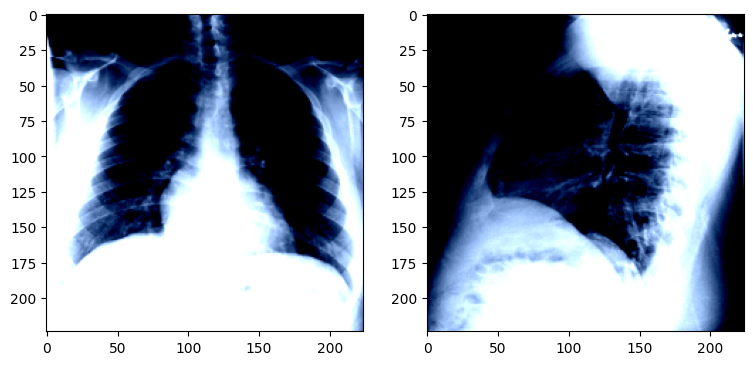

In [11]:
enc_dec_model(2,Algo = 'greedy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.453587].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  there no pleural effusion pneumothora focal airspace disease .  there stable calcified granuloma within the left lower lobe .  there are stable chronic degenerative changes the thoracic spine .  endseq


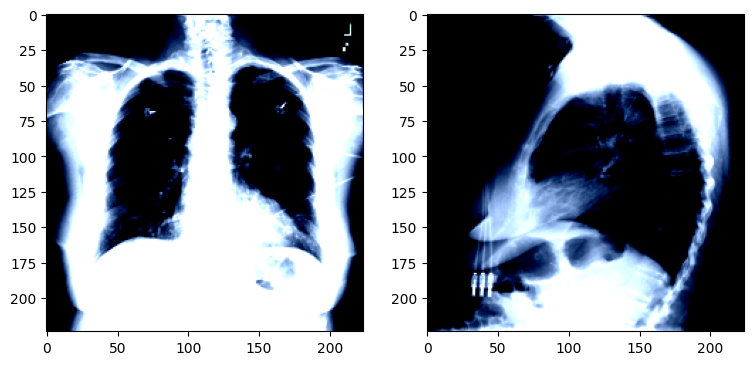

In [12]:
enc_dec_model(98,Algo = 'greedy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema .  there are irregular opacities the left lung ape that could represent cavitary lesion the left lung ape . there are streaky opacities the right upper lobe scarring .  the cardiomediastinal silhouette normal size and contour .  there no pneumothora large pleural effusion .  endseq


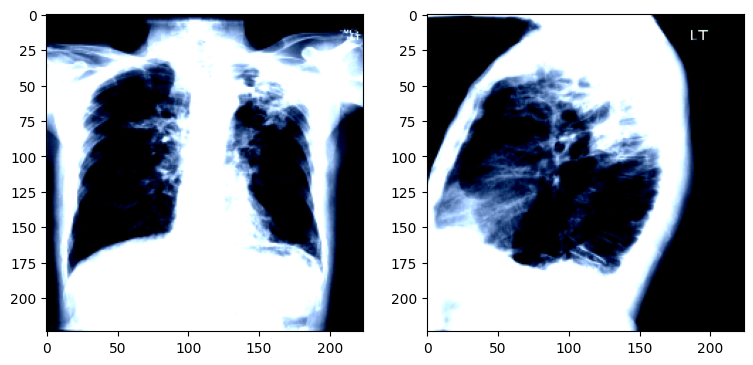

In [13]:
enc_dec_model(48,Algo = 'greedy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.423818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5222898].


------------------------------------------------------------------------------------------------------
Predicted Report :  heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen . no acute bony findings .
Score is : 0.44952184
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  the lungs are clear .  there no pneumothora pleural effusion .  the are unremarkable .  endseq


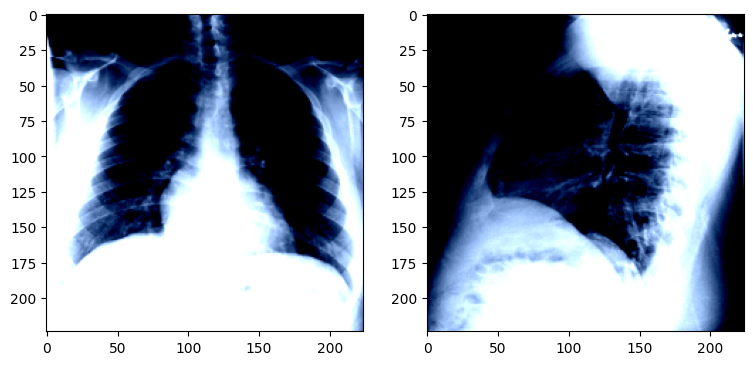

In [14]:
enc_dec_model(2,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2852962].


------------------------------------------------------------------------------------------------------
Predicted Report :  heart size and pulmonary vascularity appear within normal limits . the lungs are clear focal airspace disease pneumothora pleural effusion . there are no acute bony findings .
Score is : 0.402639
------------------------------------------------------------------------------------------------------
Actual Report :  startseq cardiac and mediastinal contours are within normal limits .  the lungs are clear .  bony structures are intact .  endseq


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0764673].


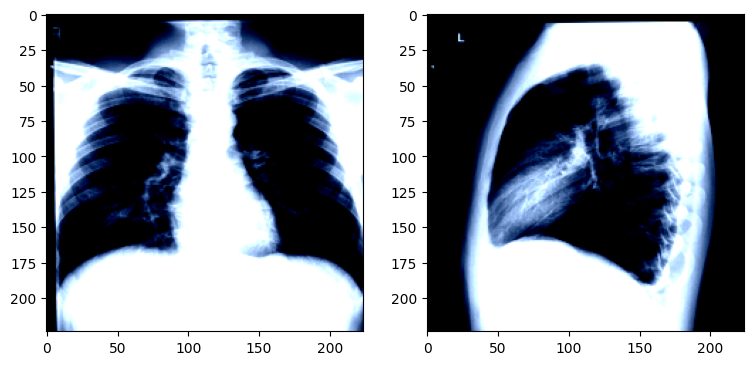

In [15]:
enc_dec_model(5,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.414225].


------------------------------------------------------------------------------------------------------
Predicted Report :  heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora . there are no acute bony findings .
Score is : 0.49141434
------------------------------------------------------------------------------------------------------
Actual Report :  startseq irregularity within the right ape consistent with patient known cavitary lesion sequela prior tuberculosis .  no evidence active infection .  no focal consolidations pneumothora effusions identified .  paramediastinal silhouette stable and within normal limits and no acute bony abnormality identified .  endseq


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.414225].


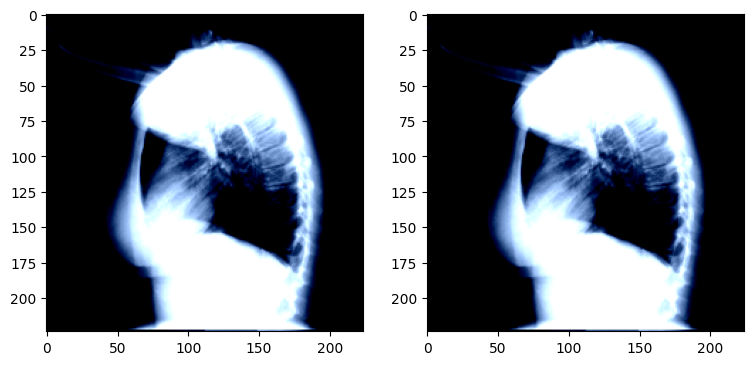

In [16]:
enc_dec_model(37,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.812323..2.1168184].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear without focal airspace disease . no pneumothora pleural effusion .
Score is : 0.43188512
------------------------------------------------------------------------------------------------------
Actual Report :  startseq there are no focal areas consolidation .  no suspicious pulmonary opacities .  heart size within normal limits .  no pleural effusions .  no evidence pneumothora .  osseous structures intact .  endseq


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1109567..1.9868859].


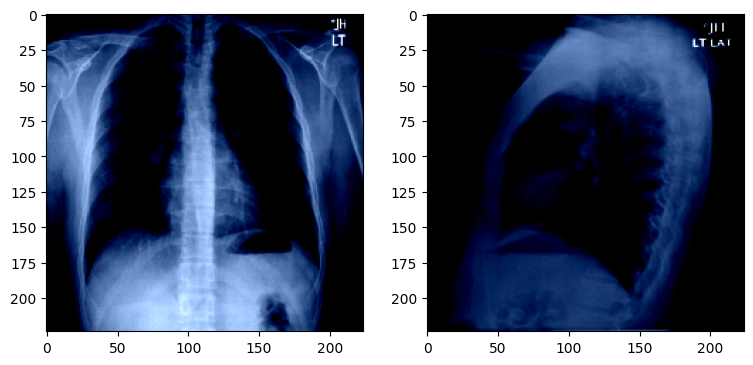

In [17]:
enc_dec_model(89,Algo = 'beam')

# Function 2

In [26]:
def enc_dec_model_pred(input_image_idx,Algo = 'greedy'):
    
    '''This fun takes index of an image as input and prints predicted result'''

    input1 = Input(shape=(2048,), name='Image_input')
    dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

    input2 = Input(shape=(153,), name='Text_Input')
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                    weights=[embedding_matrix], name="Embedding_layer")
    emb = embedding_layer(input2)

    LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
                recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
                bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
    #LSTM1_output = LSTM1(emb)

    LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
                recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
                bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
    LSTM2_output = LSTM2(LSTM1)

    dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

    dec =  tf.keras.layers.Add()([dense1, dropout1])

    fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
    fc1_output = fc1(dec)
    dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
    output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
    output = output_layer(dropout2)

    encoder_decoder = Model(inputs = [input1, input2], outputs = output)
    encoder_decoder.load_weights("/Users/payaldabas/Desktop/Project 4 /encoder_decoder_epoch_5.weights.h5")

    # encoder
    encoder_input = encoder_decoder.input[0]
    encoder_output = encoder_decoder.get_layer('dense_encoder').output
    encoder_model = Model(encoder_input, encoder_output)

    # decoder# 
    text_input = encoder_decoder.input[1]
    enc_output = Input(shape=(256,), name='Enc_Output')
    text_output = encoder_decoder.get_layer('LSTM2').output
    add1 = tf.keras.layers.Add()([text_output, enc_output])
    fc_1 = fc1(add1)
    decoder_output = output_layer(fc_1)

    decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

    def greedysearch(img):
        image = cheXnet_Features[img]
        input_ = 'startseq'
        image_features = encoder_model.predict(image)
        
        result = []
        for i in range(153):
            input_tok = [tokenizer.word_index[w] for w in input_.split()]
            input_padded = pad_sequences([input_tok], 153, padding='post')
            predictions = decoder_model.predict([input_padded, image_features])
            arg = np.argmax(predictions)
            if arg != 7:   # endseq
                result.append(tokenizer.index_word[arg])
                input_ = input_ + ' ' + tokenizer.index_word[arg]
            else:
                break
        rep = ' '.join(e for e in result)
        return rep

    def load_image(img_name):
        image = Image.open(img_name)
        X = np.asarray(image.convert("RGB"))
        X = np.asarray(X)
        X = preprocess_input(X)
        X = resize(X, (224,224,3))
        X = np.expand_dims(X, axis=0)
        X = np.asarray(X)
        return X 

    def get_result(idx=0):
        plt.figure(figsize=(9,5))
        pre_Report = greedysearch(test_data['Person_id'][idx]) # result after 20 epochs
        print('------------------------------------------------------------------------------------------------------')
        print("Predicted Report : ",pre_Report)

        plt.subplot(121)
        img = load_image(test_data['Image1'][idx])
        plt.imshow(img[0])

        plt.subplot(122)
        img = load_image(test_data['Image2'][idx])
        plt.imshow(img[0]) 

    # beam_width = 2
    def beamsearch(image, beam_width = 2):
        start = [tokenizer.word_index['startseq']]
        sequences = [[start, 0]]
        img_features = cheXnet_Features[image]
        img_features = encoder_model.predict(img_features)
        finished_seq = []

        for i in range(153):
            all_candidates = []
            new_seq = []
            for s in sequences:
                text_input = pad_sequences([s[0]], 153, padding='post')
                predictions = decoder_model.predict([text_input,img_features])
                top_words = np.argsort(predictions[0])[-beam_width:] 
                seq, score = s

                for t in top_words:
                    candidates = [seq + [t], score - np.log(predictions[0][t])]
                    all_candidates.append(candidates)
                    
            sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
            count = 0
            for seq,score in sequences:
                if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                    score = score/len(seq)   # normalized
                    finished_seq.append([seq, score])
                    count+=1
                else:
                    new_seq.append([seq, score])
            beam_width -= count
            sequences = new_seq
            if not sequences:
                break
        
        sequences = finished_seq[-1] 
        rep = sequences[0]
        score = sequences[1]
        temp = []
        rep.pop(0)
        for word in rep:
            if word != tokenizer.word_index['endseq']:
                temp.append(tokenizer.index_word[word])
            else:
                break    
        rep = ' '.join(e for e in temp)        
        return rep, score

    def get_result_beam(idx,beam_width):
        plt.figure(figsize=(9,5))
        pre_Report,Score = beamsearch(test_data['Person_id'][idx],beam_width) # result after 20 epochs
        print('------------------------------------------------------------------------------------------------------')
        print("Predicted Report : ",pre_Report)
        print('Score is :',Score)

        plt.subplot(121)
        img = load_image(test_data['Image1'][idx])
        plt.imshow(img[0])

        plt.subplot(122)
        img = load_image(test_data['Image2'][idx])
        plt.imshow(img[0])

    if Algo == 'greedy':
        get_result(input_image_idx)
    if Algo == 'beam':
        get_result_beam(input_image_idx,beam_width=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


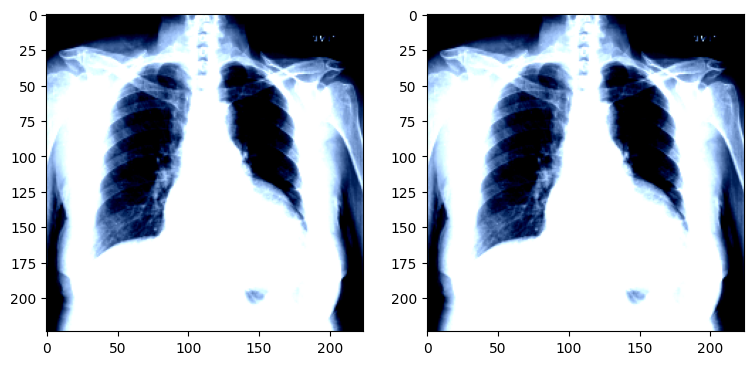

In [27]:
enc_dec_model_pred(89,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4246106].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear without evidence focal airspace disease . no pleural effusion pneumothora .
Score is : 0.43463242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3537977].


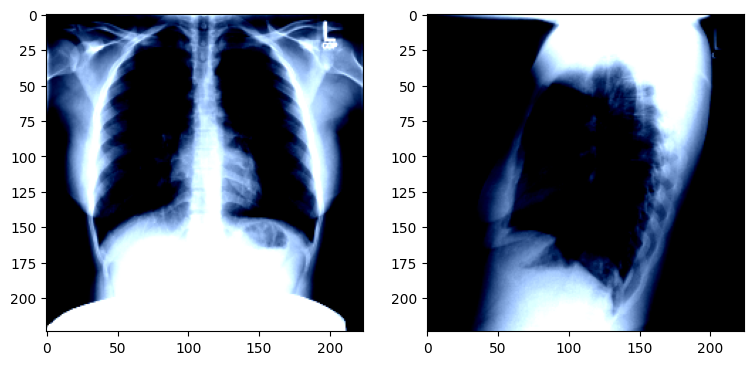

In [28]:
enc_dec_model_pred(12,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1935935].


------------------------------------------------------------------------------------------------------
Predicted Report :  heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora . there are no acute bony findings .
Score is : 0.49674523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1885839].


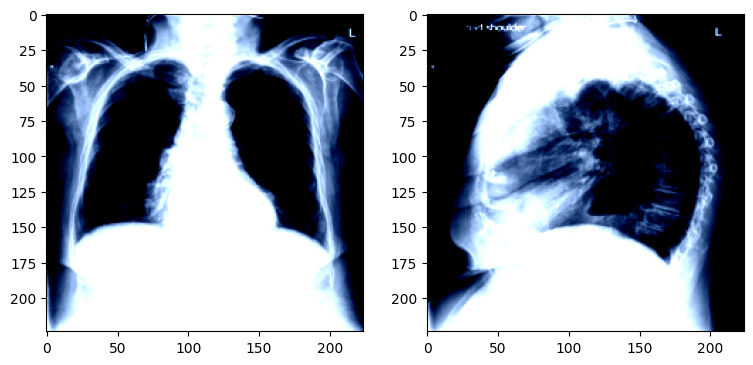

In [29]:
enc_dec_model_pred(21,Algo = 'beam')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4317787].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear without evidence focal airspace disease . no pleural effusion pneumothora .
Score is : 0.48300663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3185081].


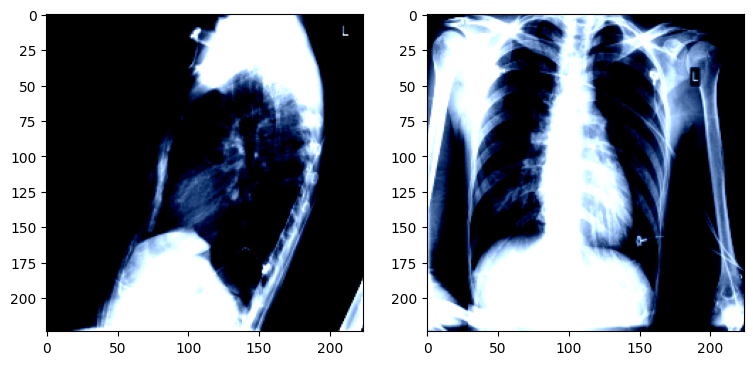

In [30]:
enc_dec_model_pred(118,Algo = 'beam')